In [5]:
"""IMPORT BIBLIOTEK"""
import mne 
import matplotlib.pyplot as plt
import numpy as np 
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs #funkcje ica
from mne_icalabel import label_components #ica-label algorytm
import onnxruntime #biblioteka do obsługi ica-label
#backend matplotliba 
%matplotlib qt 

"""WSTĘPNE USTAWIENIA PRZED WCZYTANIEM SYGNAŁU"""
d_path = "eeg_files/20241017_kp.bdf" #ścieżka do pliku
ch_eog = ["EXG1","EXG2"] #zdefiniowanie dedykowanych kanałów EOG
ch_ecg = ["EXG3","EXG4"] #zdefiniowanie dedykowanych kanałów ECG
ch_exclude = [f"EXG{i}" for i in range(5,9)] #wykluczenie kanałów niewykorzystanych w badaniu

"""ZAŁADOWANIE SYGNAŁU I USTAWIENIE UKŁADU ELEKTROD"""
raw = mne.io.read_raw_bdf(
    d_path, preload = True, eog = ch_eog, misc = ch_ecg, exclude = ch_exclude 
)
raw.set_montage("biosemi64")
bandpass_low = 0.2
bandpass_high = 30
notch = 50
raw.notch_filter(notch)
raw.filter(bandpass_low, bandpass_high)


Extracting EDF parameters from /Users/szymbierz/Desktop/wszystko/notebooks/statystyka/inne/eeg/eeg_files/20241017_kp.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2928639  =      0.000 ...  1430.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 13517 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 33793 samples (16.500 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

In [8]:
raw.interpolate_bads()

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

In [11]:
raw.interpolate_bads()


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

In [13]:
raw.set_eeg_reference("average")

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

In [15]:
ecg_events = mne.preprocessing.create_ecg_epochs(raw, ch_name='EXG3', tmin=-.1, tmax=.6, baseline=(-.1, 0), reject=dict(eeg=300e-6))
ecg_events.set_eeg_reference('average')


Using channel EXG3 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 20480 samples (10.000 s)

Number of ECG events detected : 1377 (average pulse 57.77622377622378 / min.)
Not setting metadata
1377 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1377 events and 1435 original time points ...
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Re

<Epochs | 1357 events (all good), -0.1 – 0.6 s (baseline -0.1 – 0 s), ~1.00 GiB, data loaded,
 '999': 1357>

In [19]:
a = ecg_events.average()

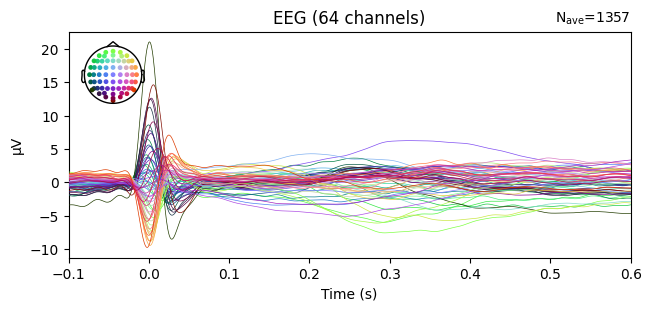

In [20]:
a.plot()

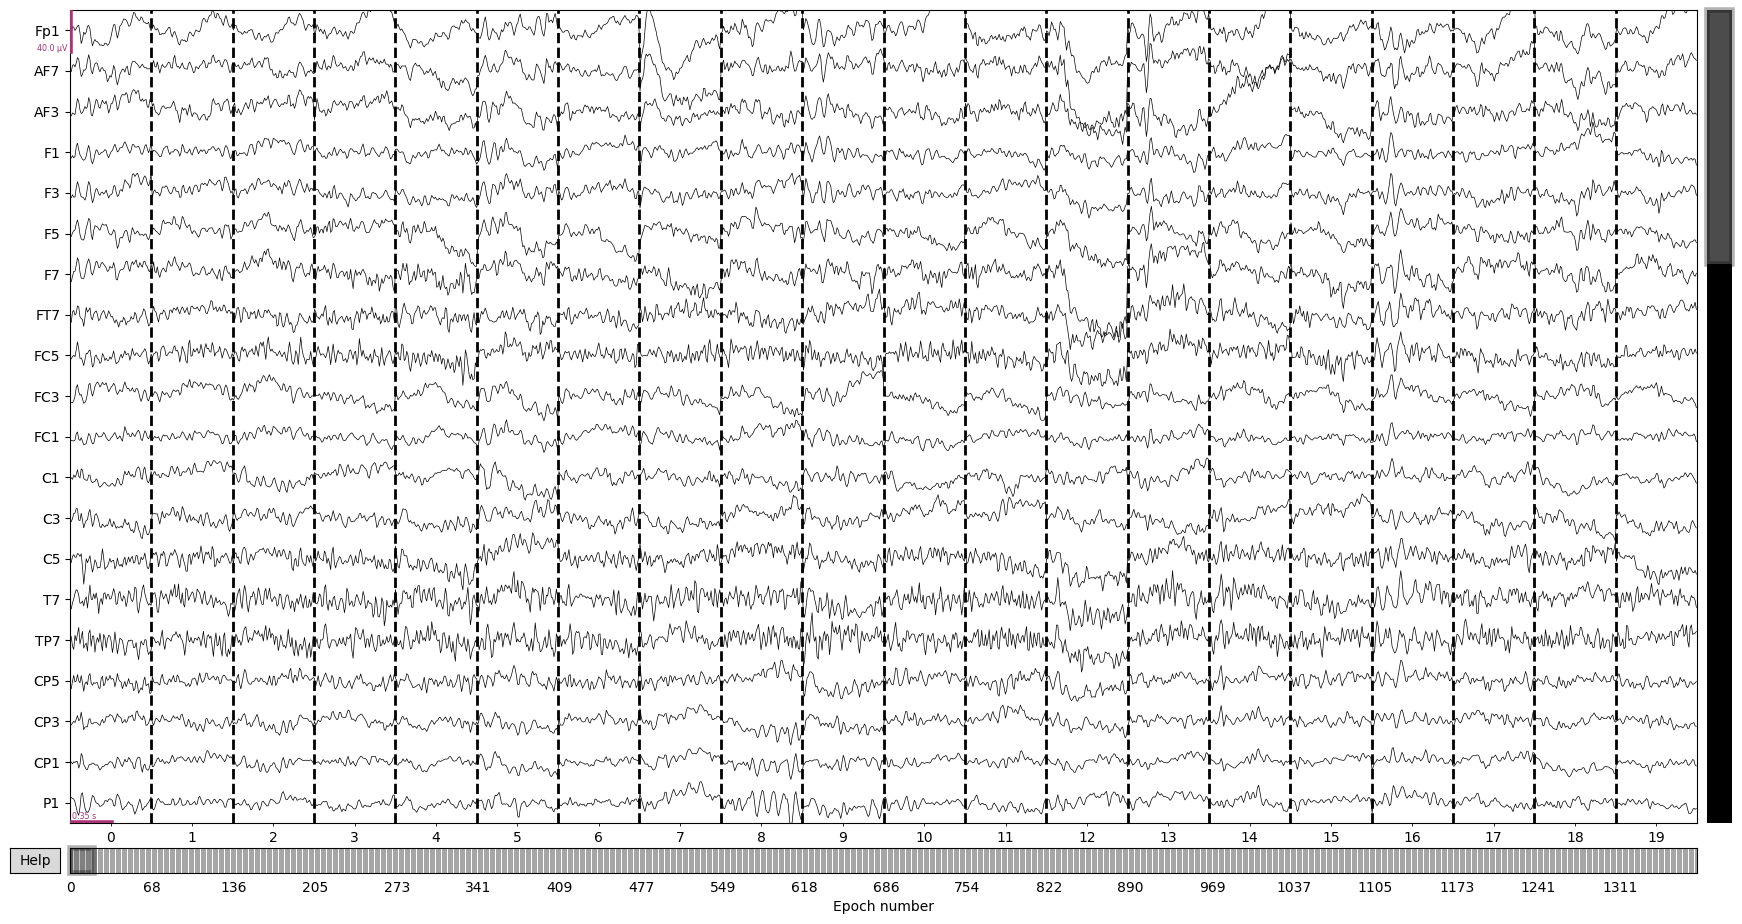

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [23]:
ecg_events.plot()

In [30]:
raw_ica = raw.copy()
raw_ica.filter(l_freq=1.0,h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

Using EOG channels: EXG1, EXG2
EOG channel index for this subject is: [64 65]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EXG2 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 421 significant peaks
Number of EOG events detected: 421
Not setting metadata
421 matching events found
No baseline correction applied
Using data from preloaded Raw for 421 events and 2049 original time points ...
0 bad epochs dropped
Applying baseli

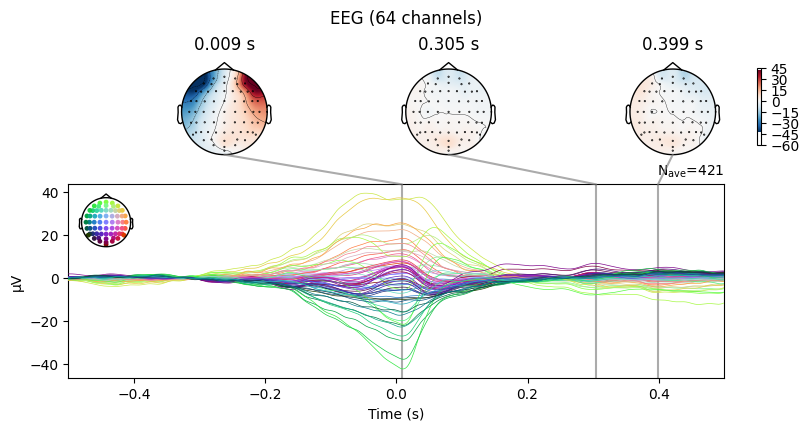

2025-05-19 11:01:38.498 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:01:38.498 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:01:38.498 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:
2025-05-19 11:01:40.998 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:01:40.998 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:01:40.998 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:


In [37]:
eog_evoked = create_eog_epochs(raw_ica).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()

Using channel EXG3 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 20480 samples (10.000 s)

Number of ECG events detected : 1377 (average pulse 57.77622377622378 / min.)
Not setting metadata
1377 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1377 events and 1435 original time points ...
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'C3', 'Fpz']
    Rejecting  epoch 

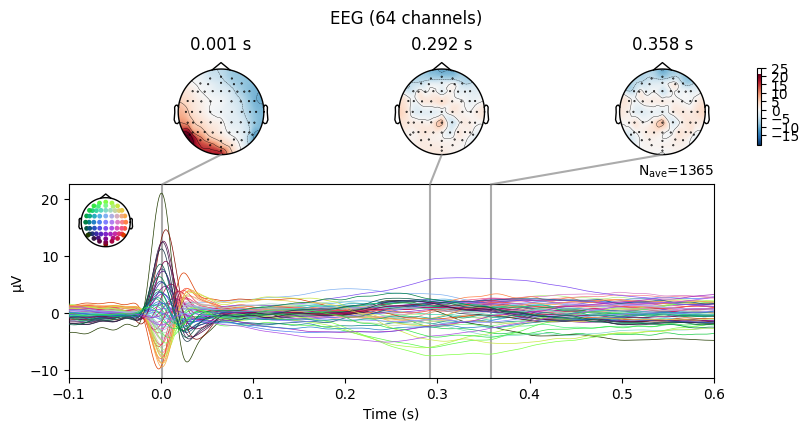

2025-05-19 11:03:46.987 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:03:46.987 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:03:46.987 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:


In [41]:
ecg_evoked = create_ecg_epochs(raw_ica,reject=dict(eeg=300e-6),ch_name="EXG3",baseline=(-.1,0),tmin=-.1,tmax=.6).average()
ecg_evoked.plot_joint()

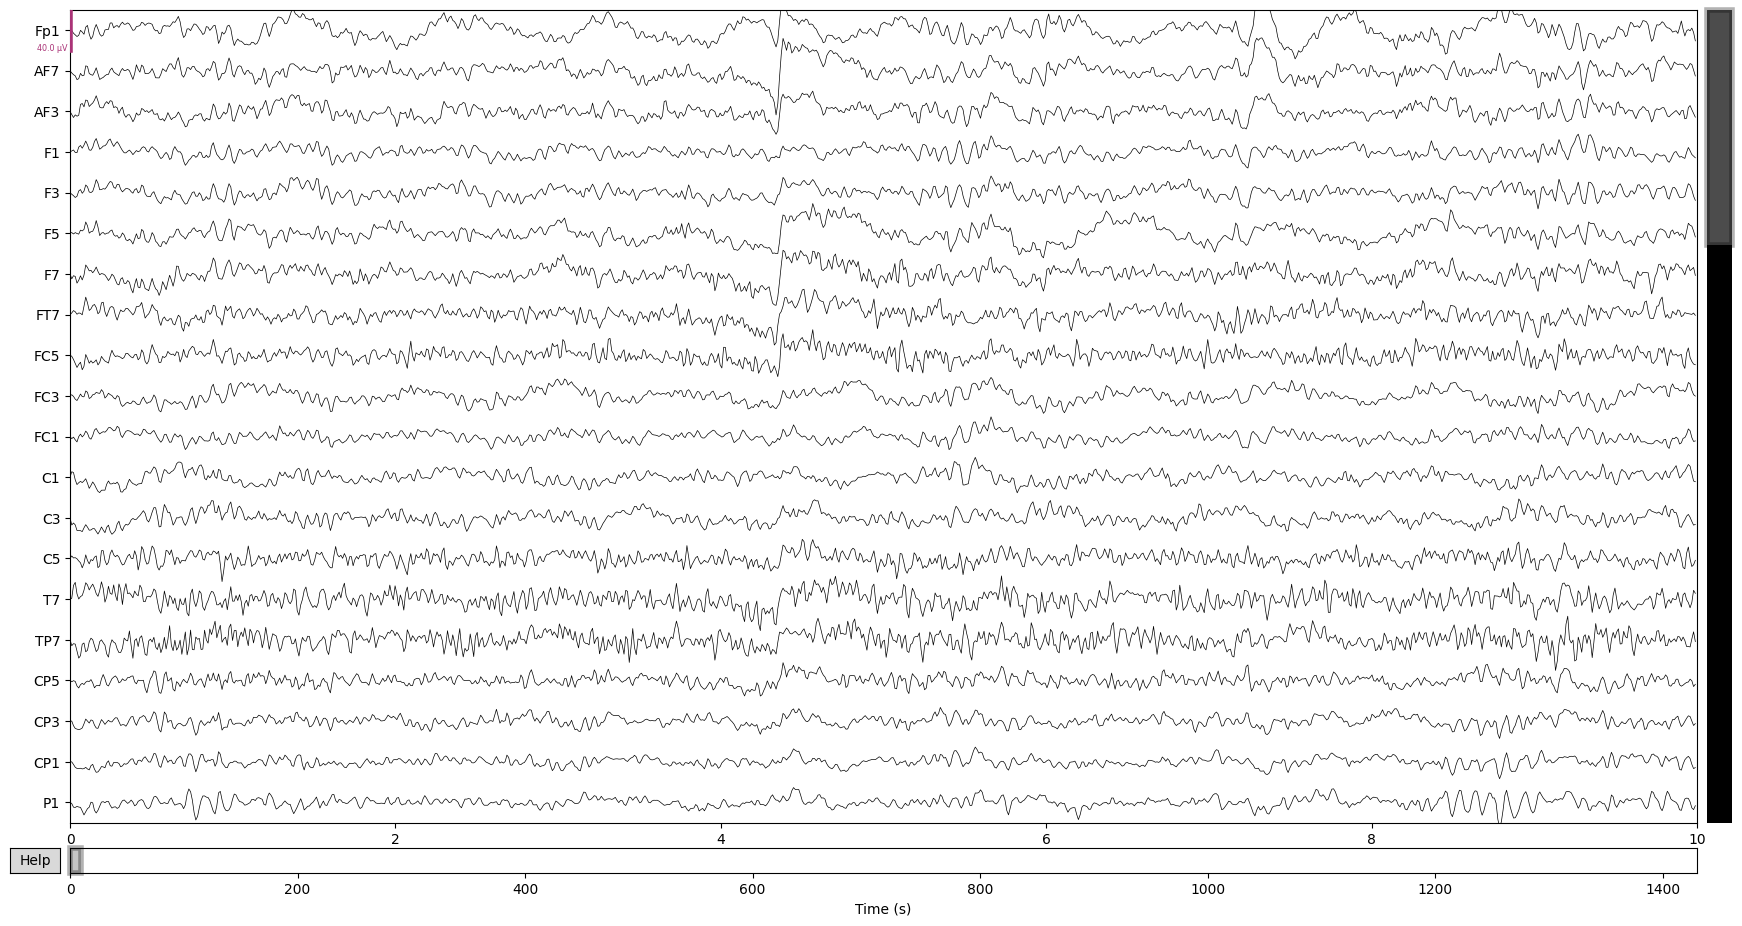

Channels marked as bad:
none


2025-05-19 11:06:27.354 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:06:27.354 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:06:27.354 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:


In [42]:
raw_ica.plot()

In [45]:
ica = mne.preprocessing.ICA(
    n_components=30, 
    max_iter='auto', 
    random_state=97
    )
ica.fit(raw_ica)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 57.0s.


<ICA | raw data decomposition, method: fastica (fit in 81 iterations on 2928640 samples), 30 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

In [46]:
ica.plot_components()

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x496 with 10 Axes>]

2025-05-19 11:27:14.819 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:27:14.819 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:27:14.819 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:


In [47]:
ica.plot_properties(raw_ica,picks=[3,6,17,29])

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

2025-05-19 11:29:00.543 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:29:00.543 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:29:00.543 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:


Creating RawArray with float64 data, n_channels=32, n_times=2928640
    Range : 0 ... 2928639 =      0.000 ...  1430.000 secs
Ready.


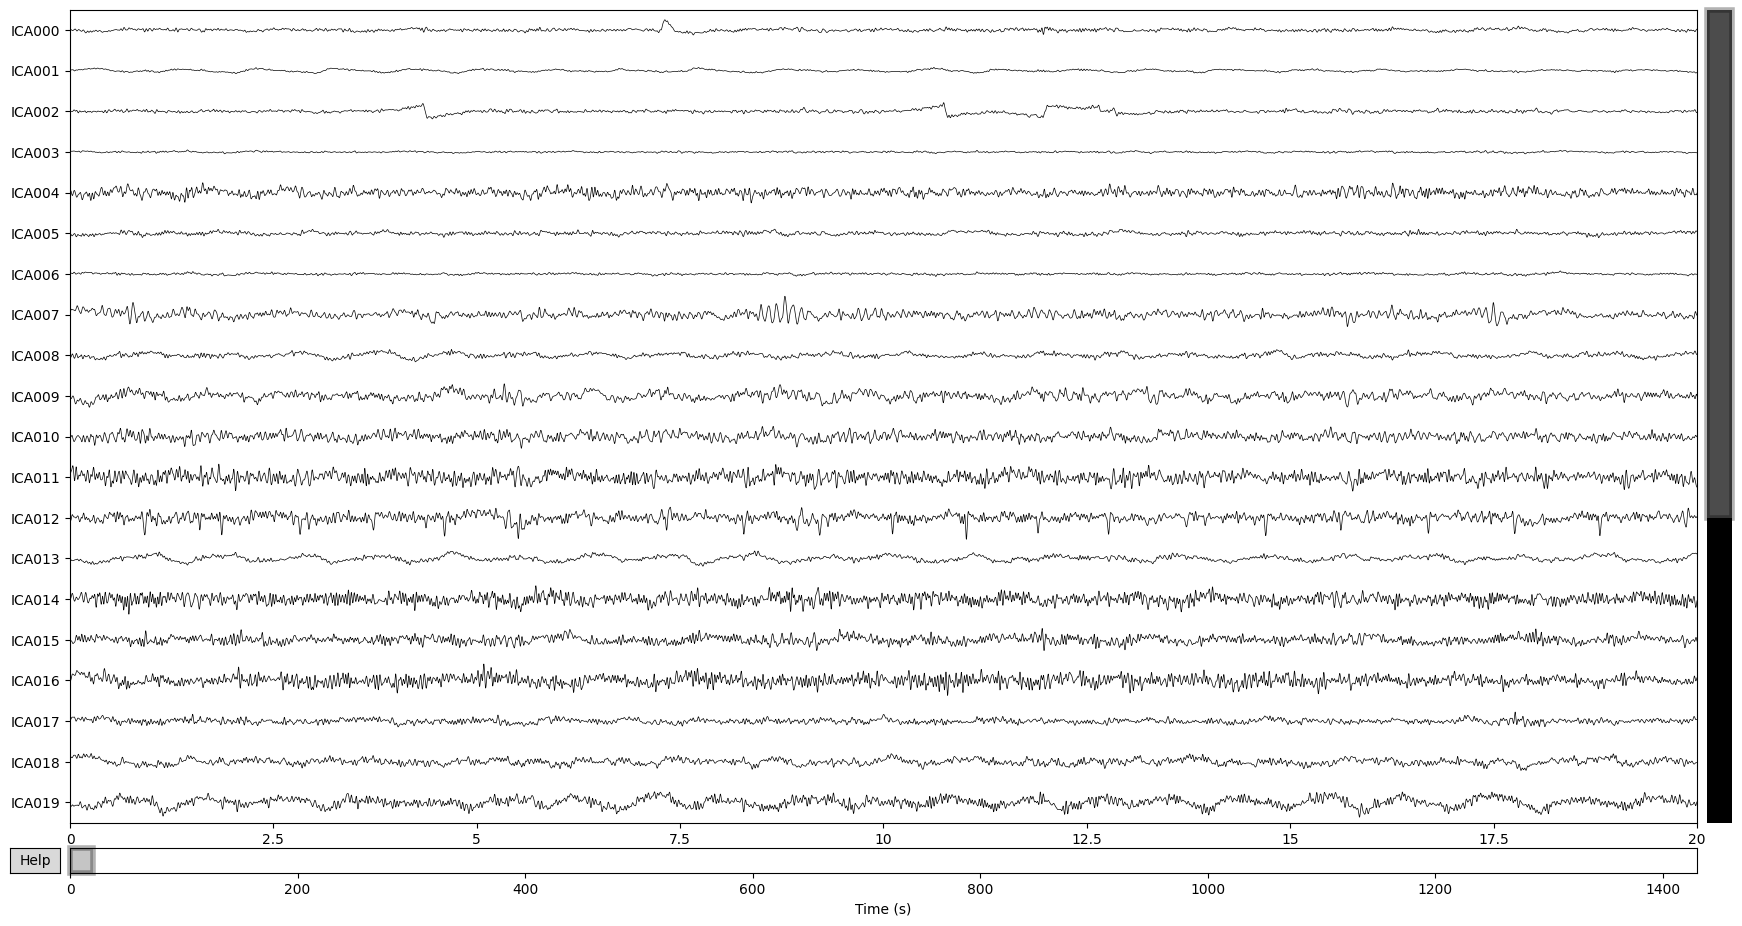

2025-05-19 11:33:44.331 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:33:44.331 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:33:44.331 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated


2025-05-19 11:34:23.495 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:34:23.495 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:34:23.495 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:


In [54]:
ica.plot_sources(raw_ica)

In [52]:
eog_indices,eog_scores = ica.find_bads_eog(raw_ica,ch_name=ch_eog)

Using EOG channels: EXG1, EXG2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)



2025-05-19 11:33:23.472 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:33:23.472 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:33:23.472 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:


In [53]:
print(eog_indices)

[np.int64(2), np.int64(0), np.int64(7)]


In [55]:
ecg_indices,ecg_scores = ica.find_bads_ecg(raw_ica,ch_name="EXG3")

Using threshold: 0.12 for CTPS ECG detection
Using channel EXG3 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 20480 samples (10.000 s)

Number of ECG events detected : 1377 (average pulse 57.77622377622378 / min.)
Not setting metadata
1377 matching events found
No baseline correction applied
Using data from preloaded Raw for 1377 events and 2049 original time points ...
0 bad epochs dropped


In [56]:
print(ecg_indices)

[np.int64(12), np.int64(19), np.int64(5), np.int64(23)]


In [57]:
emg_indices,emg_scores = ica.find_bads_muscle(raw_ica)

Effective window size : 1.000 (s)


In [58]:
print(emg_indices)

[]


In [60]:
ica.exclude=[2,0,7,12,19,5,23] 

In [61]:
ica.apply(raw,exclude=ica.exclude)

Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 7 ICA components
    Projecting back using 64 PCA components


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

In [63]:
raw_micro = raw.copy()
raw_micro.filter(l_freq = 1, h_freq = 45) 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

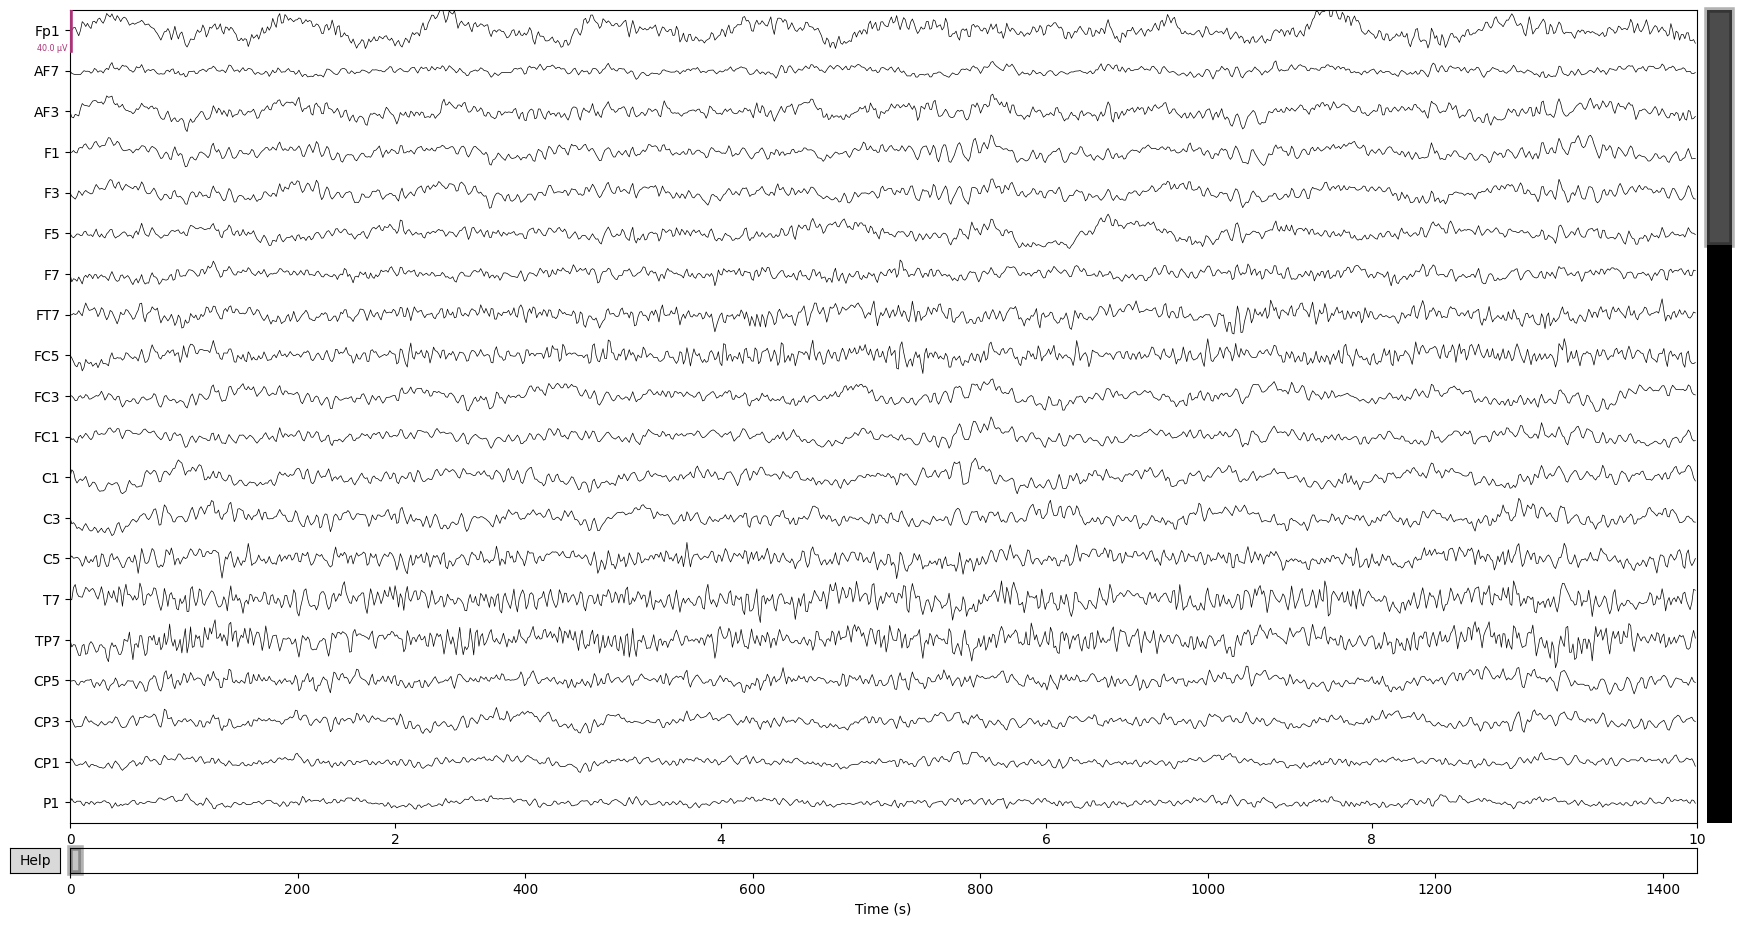

2025-05-19 11:38:35.434 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:38:35.434 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:38:35.435 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:


Channels marked as bad:
none


2025-05-19 11:40:22.665 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:40:22.665 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:40:22.665 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:


In [64]:
raw_micro.plot()

Using EOG channels: EXG1, EXG2
EOG channel index for this subject is: [64 65]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EXG2 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 421 significant peaks
Number of EOG events detected: 421
Not setting metadata
421 matching events found
No baseline correction applied
Using data from preloaded Raw for 421 events and 2049 original time points ...
0 bad epochs dropped
Applying baseli

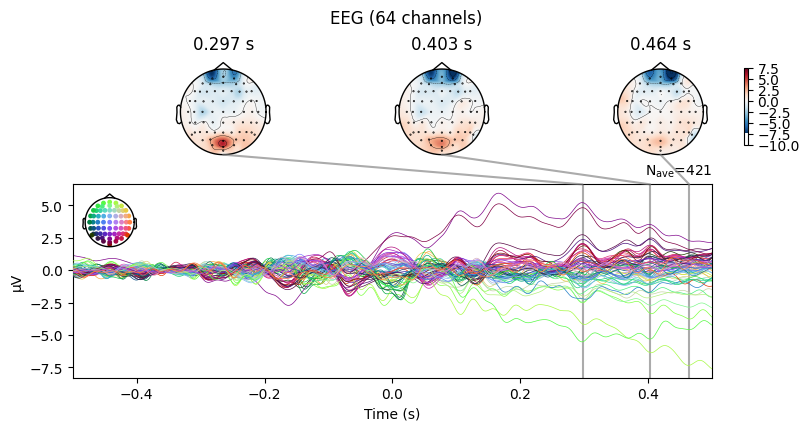

2025-05-19 11:40:58.837 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:40:58.837 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:40:58.837 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:
2025-05-19 11:41:11.697 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:41:11.697 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:41:11.697 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:


In [65]:
eog_evoked_2 = create_eog_epochs(raw_micro).average()
eog_evoked_2.apply_baseline(baseline=(None, -0.2))
eog_evoked_2.plot_joint()

In [73]:
raw_micro.crop(0,100)

<RawEDF | 20241017_kp.bdf, 69 x 204801 (100.0 s), ~107.9 MiB, data loaded>

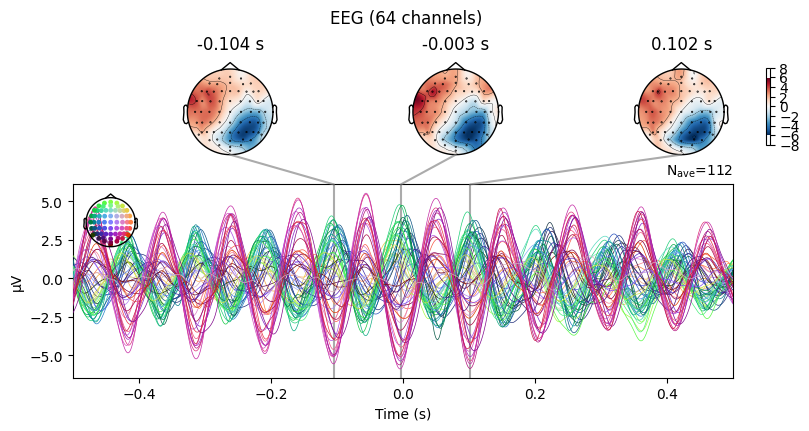

2025-05-19 11:45:01.088 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:45:01.088 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:45:01.088 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:
2025-05-19 11:45:06.035 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:45:06.035 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:45:06.035 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:


In [74]:
eog_evoked_3 = create_eog_epochs(raw_micro).average()
eog_evoked_3.apply_baseline(baseline=(None, -0.2))
eog_evoked_3.plot_joint()

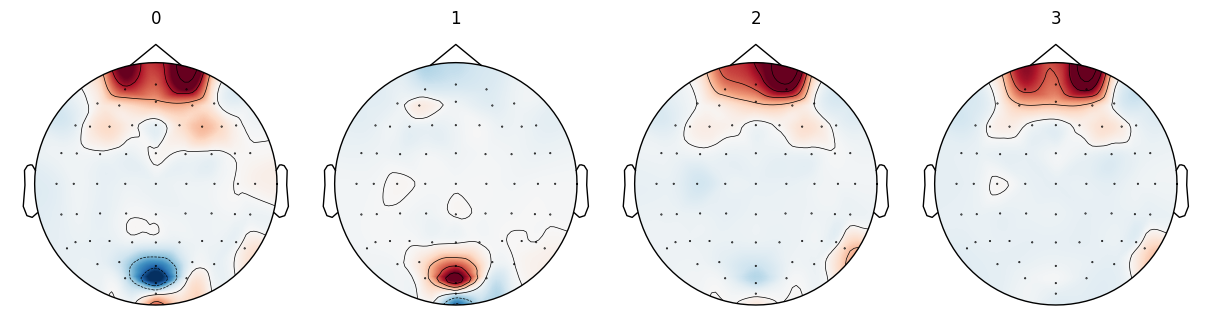

2025-05-19 11:48:20.346 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:48:20.346 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:48:20.346 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:
2025-05-19 11:48:25.187 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:48:25.187 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:48:25.187 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:


In [76]:
from pycrostates.preprocessing import extract_gfp_peaks
from pycrostates.cluster import ModKMeans
epochs = mne.make_fixed_length_epochs(raw, duration=2, preload=True)
gfp_data = extract_gfp_peaks(epochs, min_peak_distance=3)
ModK = ModKMeans(n_clusters=4, random_state=42)
ModK.fit(gfp_data, n_jobs=10, verbose="WARNING")
ModK.plot()

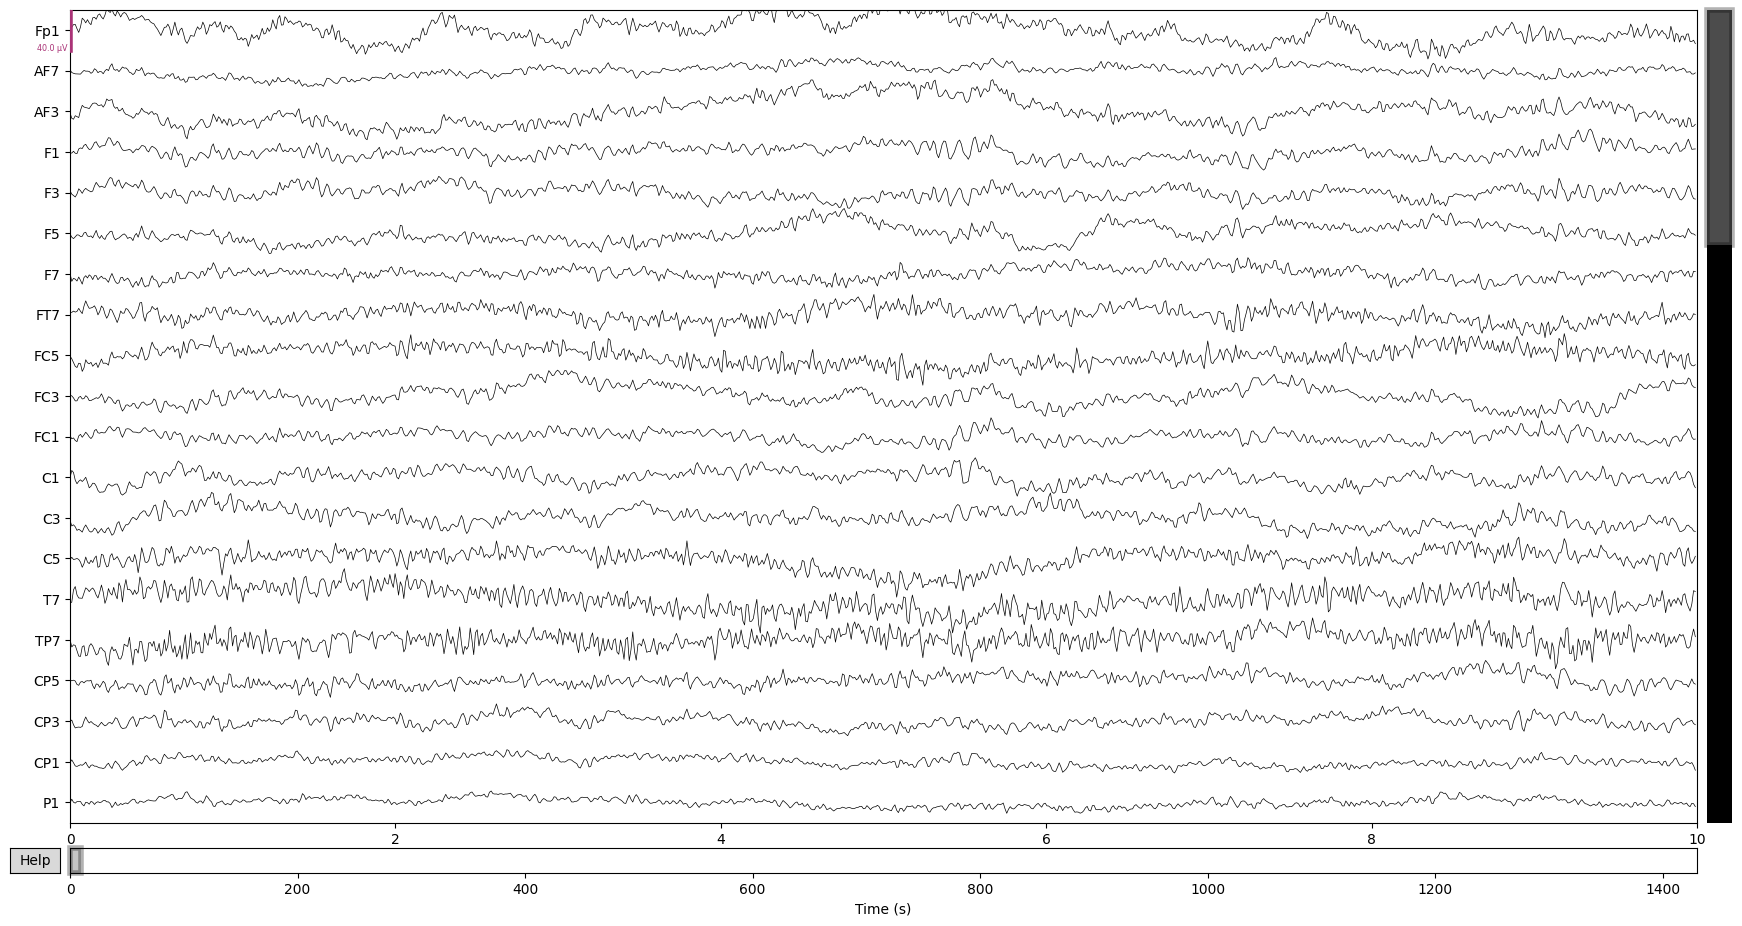

2025-05-19 11:49:13.998 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:49:13.998 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:49:13.998 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:
2025-05-19 11:50:30.023 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:50:30.023 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:50:30.023 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:


In [77]:
raw.plot()

In [84]:
epochs = mne.make_fixed_length_epochs(raw_micro, duration=4, preload=True,reject_by_annotation=True)

Exception ignored in: <function ResourceTracker.__del__ at 0x1056434c0>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107e434c0>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versi

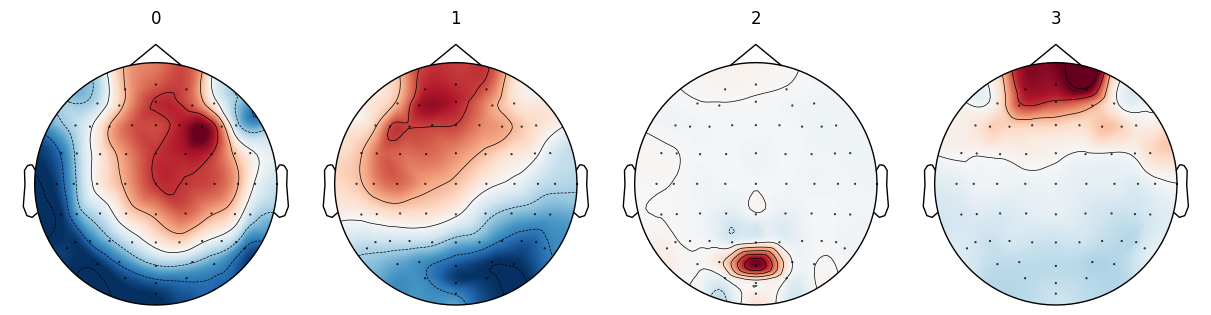

2025-05-19 11:54:08.245 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:54:08.245 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:54:08.245 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:


In [82]:
gfp_data = extract_gfp_peaks(epochs, min_peak_distance=3)
ModK = ModKMeans(n_clusters=4, random_state=42)
ModK.fit(gfp_data, n_jobs=10, verbose="WARNING")
ModK.plot()

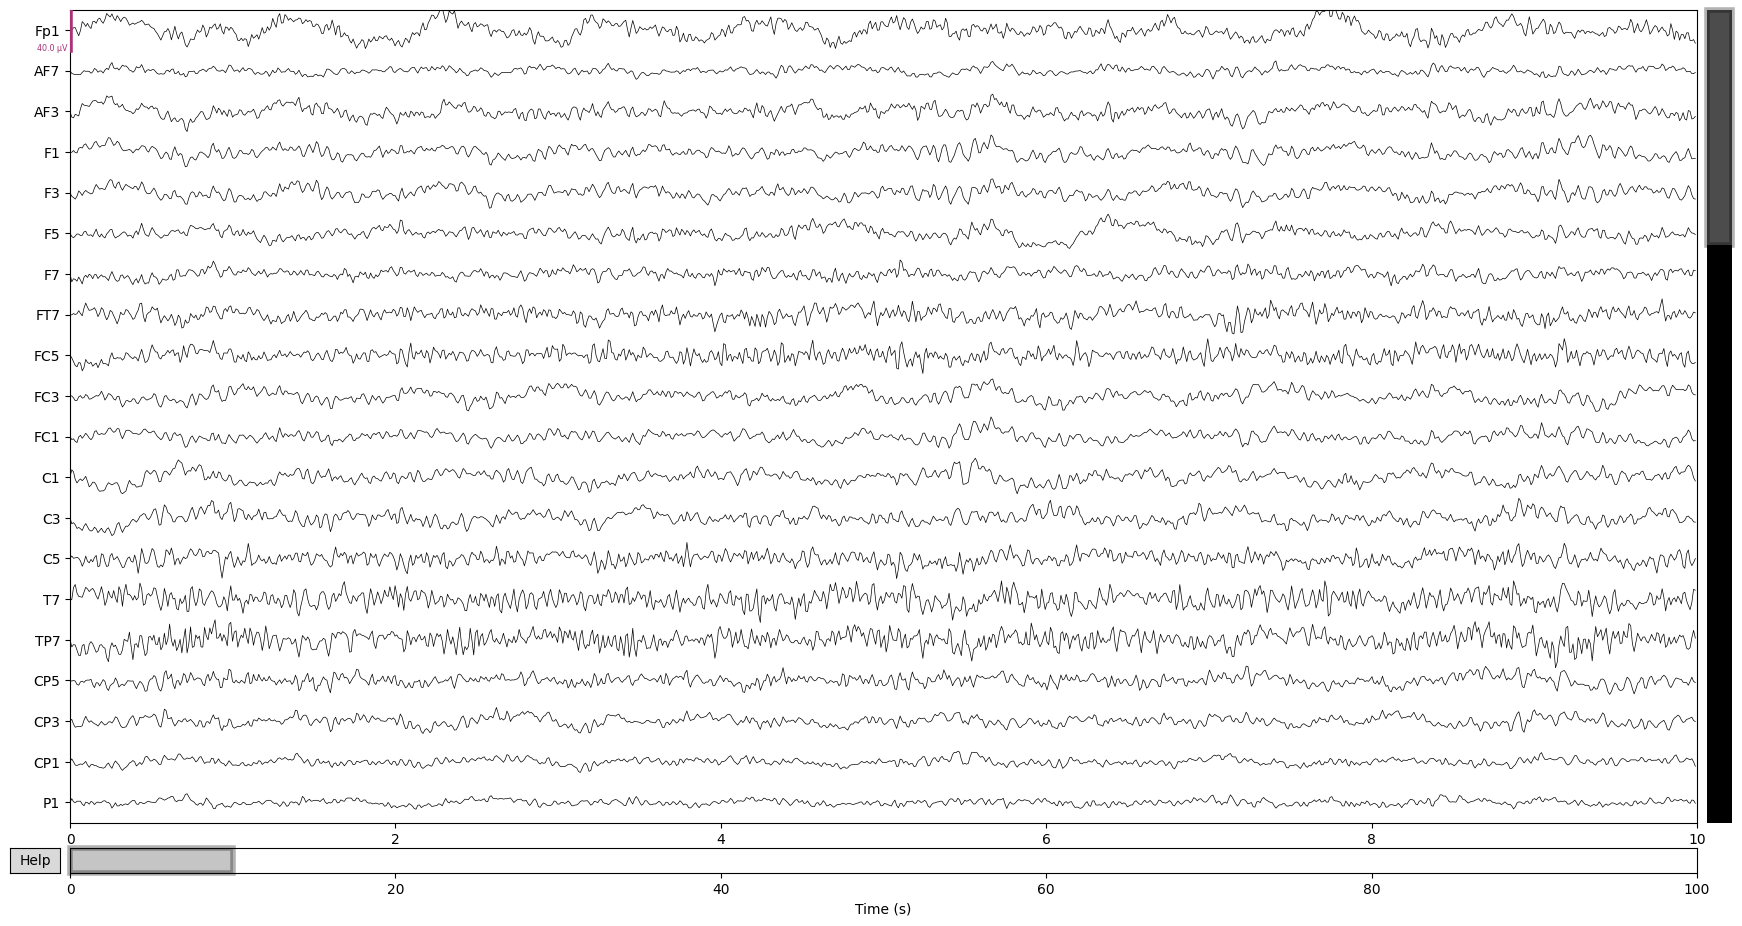

2025-05-19 11:56:14.418 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:56:14.418 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:56:14.418 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:


In [83]:
raw_micro.plot()

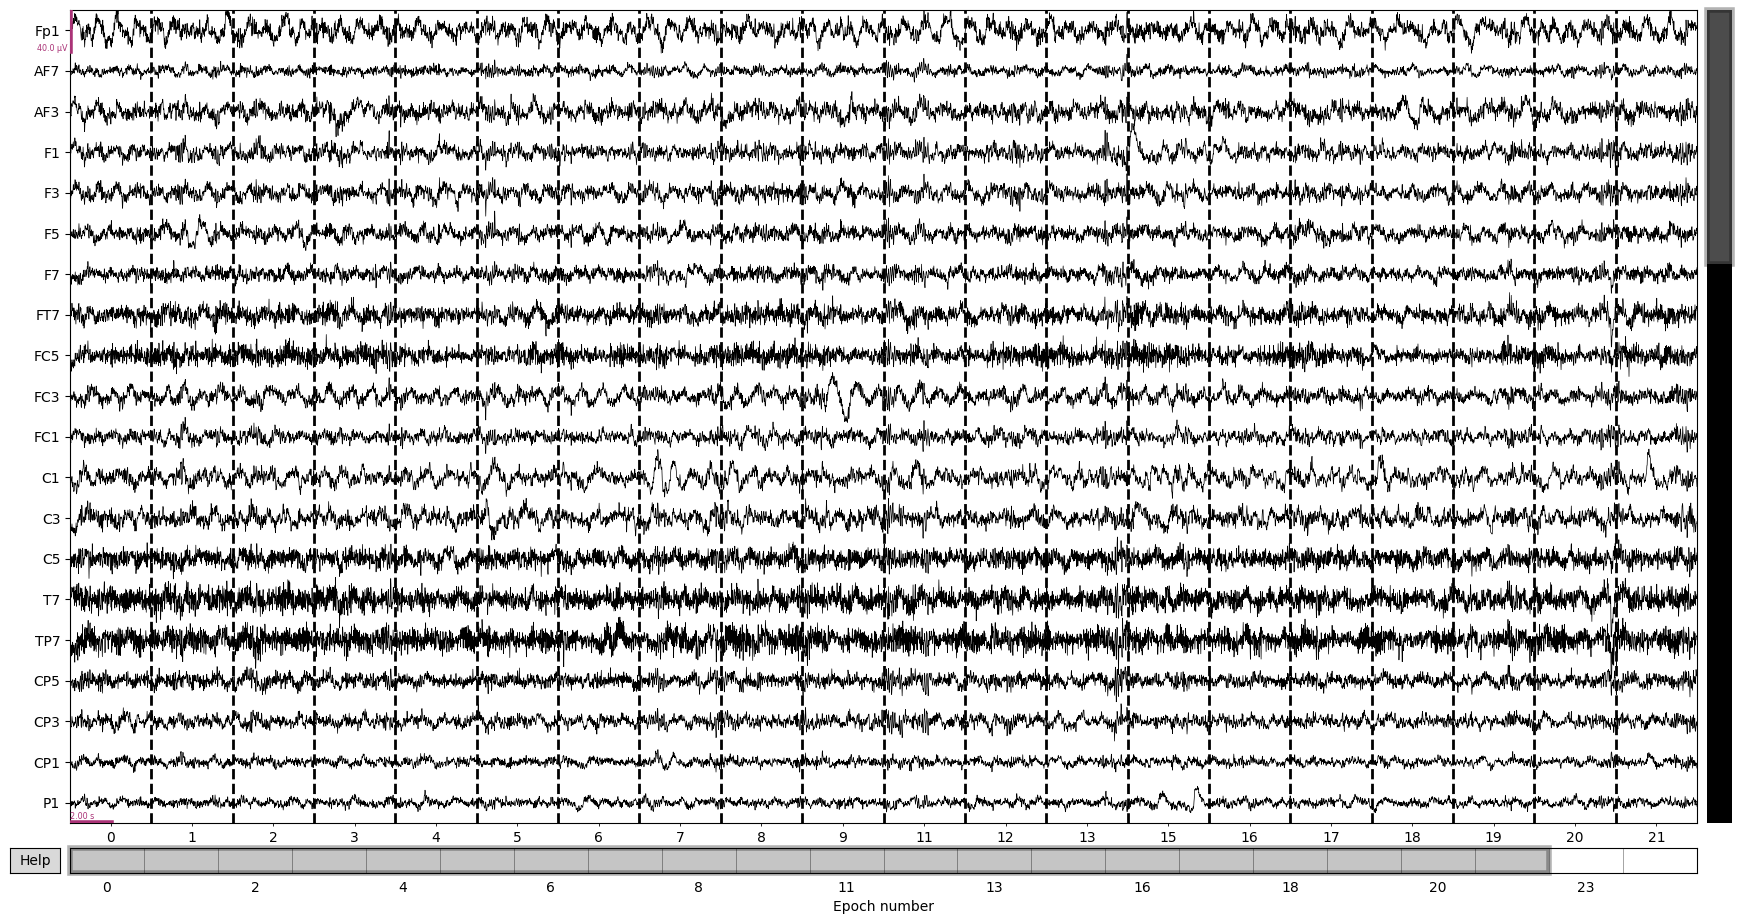

2025-05-19 11:57:51.229 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:57:51.229 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:57:51.229 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:
2025-05-19 11:58:24.687 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:58:24.687 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:58:24.687 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:


In [87]:
epochs.plot()

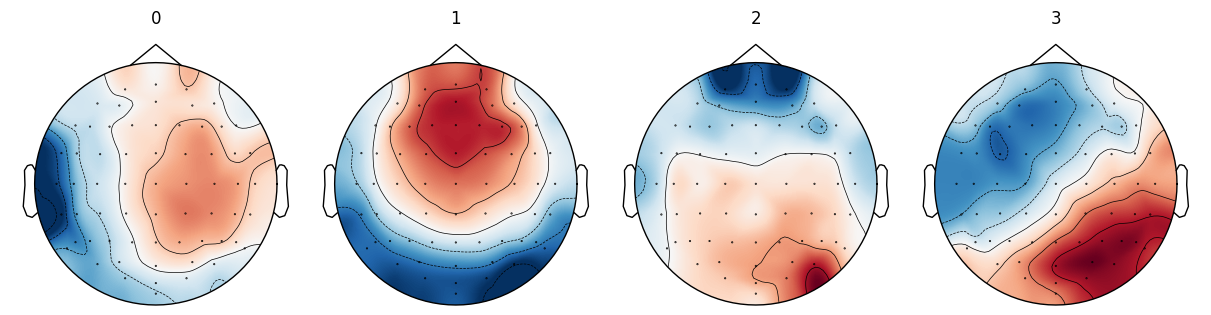

2025-05-19 11:57:25.118 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:57:25.118 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:57:25.118 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:
2025-05-19 11:57:48.466 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:57:48.466 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:57:48.466 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:


In [86]:
gfp_data = extract_gfp_peaks(epochs, min_peak_distance=3,reject_by_annotation=True)
ModK = ModKMeans(n_clusters=4, random_state=42)
ModK.fit(gfp_data, n_jobs=10, verbose="WARNING")
ModK.plot()

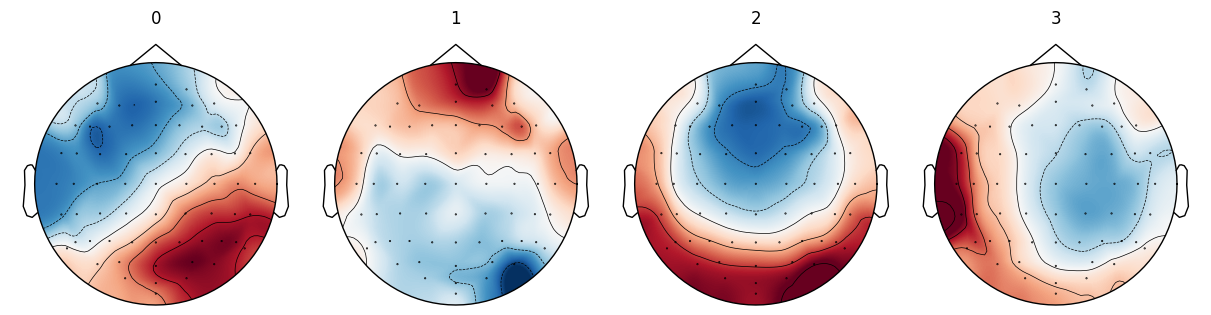

2025-05-19 11:59:05.183 Python[64569:15957311] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-19 11:59:05.183 Python[64569:15957311] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-19 11:59:05.183 Python[64569:15957311] Text input context does not respond to _valueForTIProperty:


In [89]:
gfp_data = extract_gfp_peaks(epochs, min_peak_distance=3,reject_by_annotation=True)
ModK = ModKMeans(n_clusters=4, random_state=42)
ModK.fit(gfp_data, n_jobs=100, verbose="WARNING")
ModK.plot()